<a href="https://colab.research.google.com/github/akatwinkle/bab_bab/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [24]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2023-04 다운로드 후 업로드

In [2]:
!unzip tpss_bcycl_od_statnhm_202304.zip -d tpss_bcycl_od_statnhm_202304 #압축풀

Archive:  tpss_bcycl_od_statnhm_202304.zip
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230401.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230402.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230403.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230404.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230405.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230406.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230407.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230408.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230409.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230410.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230411.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230412.csv  
  inflati

## 12-2 CSV 형태의 데이터 수집

In [3]:
import glob
import pandas as pd

## CSV 파일 목록 가져오기
all_files = glob.glob("tpss_bcycl_od_statnhm_202304/*.csv")
dataframes = []
for filename in all_files:
    ## CSV 파일 읽어서 데이터프레임화(리스트 만들기)
    df = pd.read_csv(filename, encoding='cp949') #윈도우의 한글 인코딩 방식 : cp949
    dataframes.append(df)
## 모든 데이터프레임 결합
df = pd.concat(dataframes, axis=0, ignore_index=True) # 행별로, 인덱스 무시

## 상위 5행 출력
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20230415,출발시간,0,ST-1447,전농2동_037_1,ST-1447,전농2동_037_1,1,0,0
1,20230415,출발시간,0,ST-1639,상계8동_035_1,ST-1639,상계8동_035_1,1,0,0
2,20230415,출발시간,0,ST-1661,자양4동_005_1,ST-1661,자양4동_005_1,1,0,0
3,20230415,출발시간,0,ST-243,용답동_003_1,ST-243,용답동_003_1,1,0,0
4,20230415,출발시간,0,ST-2888,우장산동_020_1,ST-2888,우장산동_020_1,1,1,0


## 12-3 기초 통계량 산출

In [4]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계 : \n", df.describe().to_markdown()) # to_markdown() : 보기 편하게 정리
## 범주형 데이터 요약 통계 출력
print("범주형 데이터 요약 통계 : \n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계 : 
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 7.76947e+06 |    7.76947e+06 |  7.76947e+06 |    7.76947e+06 |      7.76947e+06 |
| mean  | 2.02304e+07 | 1451.5         |  1.07513     |   22.9326      |   2704.27        |
| std   | 8.52204     |  561.131       |  0.309264    |   31.5494      |  11951.9         |
| min   | 2.02304e+07 |    0           |  1           |    0           |      0           |
| 25%   | 2.02304e+07 | 1020           |  1           |    6           |    854           |
| 50%   | 2.02304e+07 | 1600           |  1           |   12           |   1551           |
| 75%   | 2.02304e+07 | 1855           |  1           |   27           |   2990           |
| max   | 2.02304e+07 | 2355           | 17           | 2001           |      1.29444e+07 |
범주형 데이터 요약 통계 : 
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명

## 12-4 결측치 및 이상치 제거

In [5]:
## 결측치 제거
df = df.dropna()
## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
df = df[(df['전체_이용_분'] > 1) & (df['전체_이용_분'] < 180)]

## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
df = df[(df['전체_이용_거리'] > 10) & (df['전체_이용_거리'] < 1000)]

## '집계_기준' 컬럼 필터링 (출발시간만 사용)
df = df[df['집계_기준'] == '출발시간']


## 12-5 날짜/시간 데이터 형식 변환

In [6]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
df['기준_날짜'] = pd.to_datetime(df['기준_날짜'], format = '%Y%m%d')
## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}
df['요일'] = df['기준_날짜'].dt.day_name().map(day_mapping) # day_name() : 요일을 영어로 출력하는 함수


## 전처리 결과 확인

In [7]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       | 기준_날짜                     |   기준_시간대 |     전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|:------------------------------|--------------:|--------------:|---------------:|-----------------:|
| count | 985375                        |    985375     | 985375        |   985375       |       985375     |
| mean  | 2023-04-15 20:20:56.502752768 |      1413.35  |      1.01304  |        8.19529 |          669.413 |
| min   | 2023-04-01 00:00:00           |         0     |      1        |        2       |           11     |
| 25%   | 2023-04-09 00:00:00           |       935     |      1        |        3       |          529     |
| 50%   | 2023-04-16 00:00:00           |      1515     |      1        |        5       |          700     |
| 75%   | 2023-04-23 00:00:00           |      1845     |      1        |        7       |          845     |
| max   | 2023-04-30 00:00:00           |      2355     |      6        |      179       |          999     |
| std   | nan     

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [8]:
## 요일별 이용량 계산 및 정렬
day_df = df['요일'].value_counts().reindex(day_mapping.values())
## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

요일별 이용량:
 요일
월요일    166349
화요일    119176
수요일    131847
목요일    142324
금요일    164969
토요일    129720
일요일    130990
Name: count, dtype: int64


## 12-7 요일별 이용량 시각화

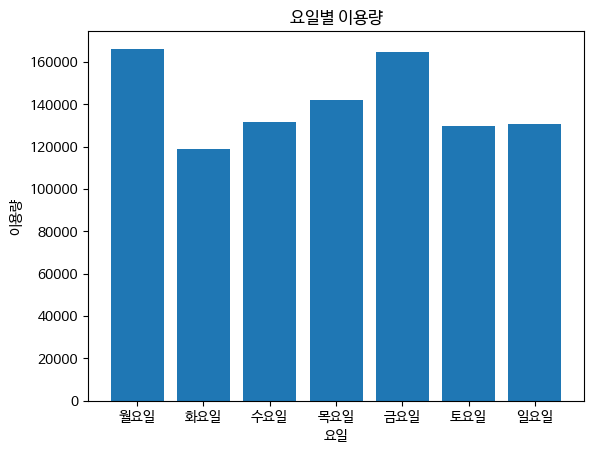

In [9]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.bar(day_df.index, day_df.values)
plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

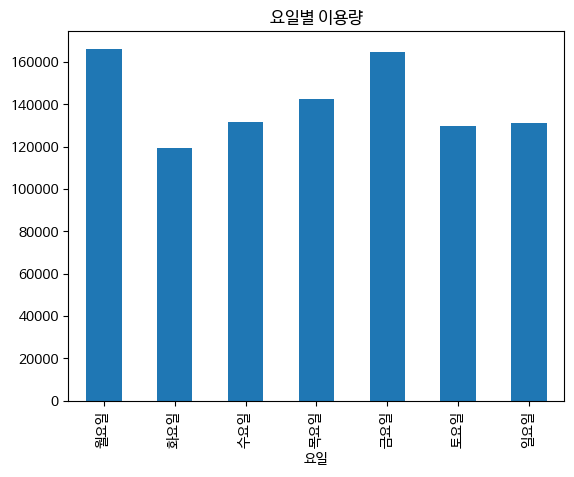

In [10]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
day_df.plot(kind='bar')
plt.title('요일별 이용량')
plt.show()

## 12-8 시간별 이용량 분석 및 시각화

시간별 이용량:
 출발_시
0     20037
1     12708
2      7999
3      5358
4      4179
5      9088
6     22943
7     53425
8     80726
9     50807
10    36904
11    41416
12    44574
13    44518
14    44007
15    48851
16    60231
17    76746
18    91973
19    64575
20    49616
21    46837
22    41789
23    26068
Name: count, dtype: int64


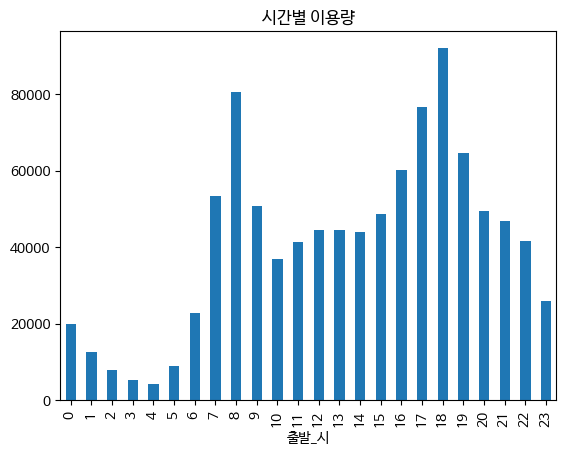

In [11]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100) #df의 기준_시간대는 빌린시간/분이 합쳐져 있음 그래서 100으로 나눔
df['출발_시'] = df['기준_시간대'] // 100    #몫만 출력

## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df = df['출발_시'].value_counts().sort_index()

## 시간별 이용량 출력
print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.title("시간별 이용량")
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
2023-04-01    31576
2023-04-02    28180
2023-04-03    41398
2023-04-04    35280
2023-04-05     7117
2023-04-06    18646
2023-04-07    37315
2023-04-08    29151
2023-04-09    25976
2023-04-10    40988
2023-04-11    30180
2023-04-12    39707
2023-04-13    40463
2023-04-14    42389
2023-04-15    22631
2023-04-16    25123
2023-04-17    41443
2023-04-18    26586
2023-04-19    43555
2023-04-20    39481
2023-04-21    43392
2023-04-22    33224
2023-04-23    28135
2023-04-24    42520
2023-04-25    27130
2023-04-26    41468
2023-04-27    43734
2023-04-28    41873
2023-04-29    13138
2023-04-30    23576
Name: count, dtype: int64


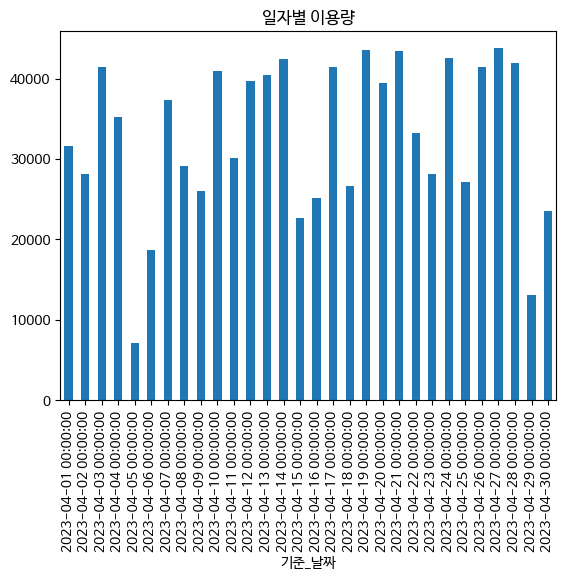

In [12]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.title("일자별 이용량")
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2023_04.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [13]:
## 강수량 데이터 CSV 파일 로드
file_path = 'seoul_rain_2023_04.csv'
rain_df = pd.read_csv(file_path, encoding='cp949', skiprows=12) # skiprows 제외할 행수
rain_df.head(5)

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,\t지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각,Unnamed: 6
0,108,서울,2023-04-01,NaN,NaN,NaN,NaN
1,108,서울,2023-04-02,NaN,NaN,NaN,NaN
2,108,서울,2023-04-03,NaN,NaN,NaN,NaN
3,108,서울,2023-04-04,6.9,3.1,21:38,NaN
4,108,서울,2023-04-05,50.3,9.0,12:10,NaN


## 12-11 강수량 데이터 전처리

In [14]:
## '일시' 컬럼 datetime 형식으로 변환
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')
## '강수량(mm)' 컬럼 결측치 0으로 채우기
rain_df['강수량(mm)'] = rain_df['강수량(mm)'].fillna(0)
## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed: 6'], inplace=True)

## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [16]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_gf의 기준_날짜, rain_df의 일시를 기준으로 결합)
merged_df = pd.merge(daily_usage_df, rain_df, how = 'left', left_on='기준_날짜', right_on='일시')
## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,이용량,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,31576,서울,2023-04-01,0.0,NaN,NaN
1,28180,서울,2023-04-02,0.0,NaN,NaN
2,41398,서울,2023-04-03,0.0,NaN,NaN
3,35280,서울,2023-04-04,6.9,3.1,21:38
4,7117,서울,2023-04-05,50.3,9.0,12:10


## 12-13 이용량 및 강수량 시각화

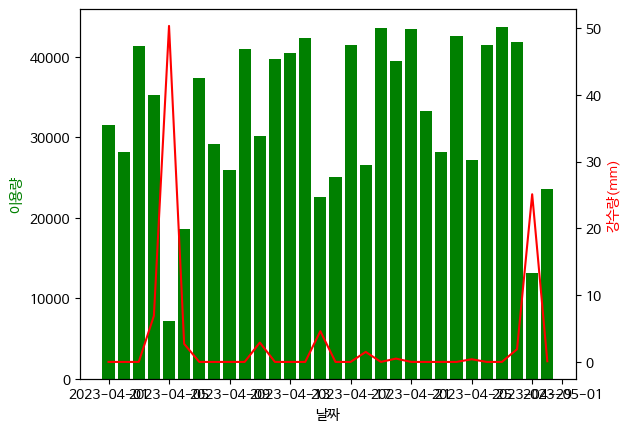

In [22]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기
ax1.bar(merged_df['일시'], merged_df['이용량'], color = 'g')

## 두 번째 y축에 강수량 꺾은선 그래프 그리기
ax2.plot(merged_df['일시'], merged_df['강수량(mm)'], color = 'r')

## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='g')
ax2.set_ylabel('강수량(mm)', color='r')

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

강수량과 이용량의 상관계수: -0.7227291898852147


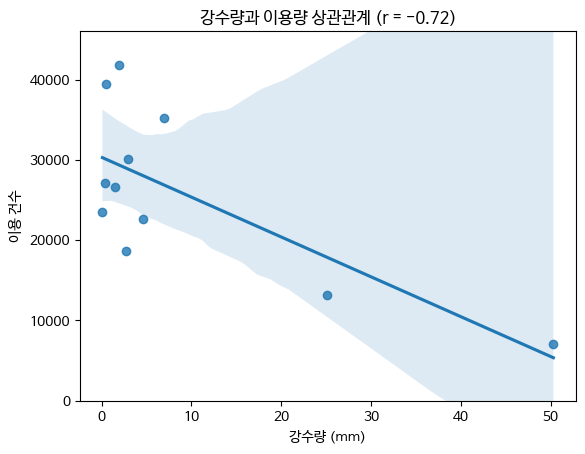

In [23]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]
## 강수량과 이용량의 상관계수 계산
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성
ax = sns.regplot(x = '강수량(mm)', y = '이용량', data = merged_onlyrain_df)

## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [24]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (statsmodels는 () 사용시 오류)(formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True)

## OLS 모델 정의 및 학습
model = smf.ols(formula='이용량 ~ 강수량_mm', data = merged_onlyrain_df)
results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석
print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")

                            OLS Regression Results                            
Dep. Variable:                    이용량   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     9.842
Date:                Thu, 27 Nov 2025   Prob (F-statistic):             0.0120
Time:                        04:58:20   Log-Likelihood:                -113.02
No. Observations:                  11   AIC:                             230.0
Df Residuals:                       9   BIC:                             230.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.034e+04   2721.732     11.148      0.0